In [1]:
from utils_2 import *
from keras.models import load_model
import matplotlib.pyplot as plt
from glob import glob
import os
import pandas as pd 
import numpy as np
from sklearn.metrics import confusion_matrix,plot_roc_curve,auc,roc_auc_score,roc_curve
from sklearn.utils.multiclass import unique_labels

In [2]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(classes)-0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [3]:
# KS法
def Find_Optimal_Cutoff_ks(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value
        
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 



In [4]:
# 约登指数
def sensivity_specifity_cutoff(y_true, y_score):
    '''Find data-driven cut-off for classification
    
    Cut-off is determied using Youden's index defined as sensitivity + specificity - 1.
    
    Parameters
    ----------
    
    y_true : array, shape = [n_samples]
        True binary labels.
        
    y_score : array, shape = [n_samples]
        Target scores, can either be probability estimates of the positive class,
        confidence values, or non-thresholded measure of decisions (as returned by
        “decision_function” on some classifiers).
        
    References
    ----------
    
    Ewald, B. (2006). Post hoc choice of cut points introduced bias to diagnostic research.
    Journal of clinical epidemiology, 59(8), 798-801.
    
    Steyerberg, E.W., Van Calster, B., & Pencina, M.J. (2011). Performance measures for
    prediction models and markers: evaluation of predictions and classifications.
    Revista Espanola de Cardiologia (English Edition), 64(9), 788-794.
    
    Jiménez-Valverde, A., & Lobo, J.M. (2007). Threshold criteria for conversion of probability
    of species presence to either–or presence–absence. Acta oecologica, 31(3), 361-369.
    '''
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    idx = np.argmax(tpr - fpr)
    return thresholds[idx]

## 测试集定义-通用

In [5]:
# 给定测试集患者id----需手动——注意与模型训练保持不变
test_id = list(range(285,293))
test_id.extend(list(range(419,439)))
test_id.extend(list(range(1,84)))
test_id.extend(list(range(439,473)))
test_id.extend([259,294])
print(len(test_id))

147


In [6]:
def Evaluate(model_stage, adr_list, Size_list):
    model_name_list = ['Inception', 'Vgg', 'Resnet']
    # 计算预测值
    ## Incpt = 1
    model_name = 1
    print('Stage: ', model_stage)
    print('Model: ', model_name_list[model_name-1])
    print('View: ',Size_list[model_name-1])
    score_1, Y_true = score_predict(model_name,model_stage,adr_list[model_name-1],Size_list[model_name-1])
    ## Vgg = 2
    model_name = 2
    print('Model: ', model_name_list[model_name-1])
    print('View: ',Size_list[model_name-1])
    score_2, Y_true = score_predict(model_name,model_stage,adr_list[model_name-1],Size_list[model_name-1])
    ## Res = 3
    model_name = 3
    print('Model: ', model_name_list[model_name-1])
    print('View: ',Size_list[model_name-1])
    score_3, Y_true = score_predict(model_name,model_stage,adr_list[model_name-1],Size_list[model_name-1])
    # 计算评价指标
    criteria([score_1,score_2,score_3],Y_true)

In [7]:
def score_predict(model_name, model_stage, model_adr, Size, 
            data_file = '/course75/RealData/', datflag_file = 'datflag636.csv'):
    # model_name使用模型：1为Inception，2为vgg，3为resnet
    # model_stage任务阶段
    # data文件所在位置前缀，默认为空，若非空，以/结尾
    # data_file = '/course75/RealData/'
    # datflag_file csv文件所在位置
    # 分类类别
    Class_num = get_task(model_stage)
    # 测试集batchsize需设置为1
    params_val = {'dim': (Size[1],Size[1],Size[1]),
              'batch_size': 1,
              'n_classes': Class_num,
              'n_channels': 3,
              'shuffle': False,
              'Size': [Size[0],Size[1],Size[2]],
              'data_file': data_file}
    partition, labels=get_par_lab(datflag_file=datflag_file, data_file=data_file, stage = model_stage, test_id=test_id)
    print('train length: ',len(partition['train']))
    print('test length: ',len(partition['test']))
    print('label length: ',len(labels))
    # Generators——仅生成测试集的生成器
    validation_generator = DataGenerator(partition['test'], labels, **params_val)
    # 读取模型
    model = load_model(model_adr)
    # 存储三个模型预测结果
    score = []
    Y_true = []
    for X_pre, Y_pre in validation_generator:    
        score.append(model.predict(X_pre)[0])
        Y_true.append(Y_pre)
    return score, Y_true

In [15]:
def Plot_ROC(Y_true_list,Y_score):
    fpr, tpr, thresholds = roc_curve(Y_true_list, Y_score) 
    roc_auc=roc_auc_score(Y_true_list, Y_score)
    plt.figure(figsize=(5,4))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='Our model (AUC %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Sensitivity')
    plt.ylabel('1-Specificity')
    plt.legend(frameon=False, loc="lower right")
    plt.grid(linestyle='-.')
    plt.savefig(model_stage+'_ROC.pdf', bbox_inches='tight')
    plt.show()

In [9]:
def criteria(score_list, Y_true):
    # 使用投票法
    score = np.sum(score_list, axis = 0)/3
    # 计算真实Y和预测Y
    Y_true_list=[]
    for i in range(len(Y_true)):
        temp=list(Y_true[i][0])
        Y_true_list.append(temp.index(max(temp)))
    Y_hat = []
    Y_score = []
    for i in range(len(score)):
        Y_hat.append(list(score[i]).index(max(score[i])))
        Y_score.append(score[i][1])
    if model_stage == 'task3':
        # 混淆矩阵
        cm = confusion_matrix(Y_true_list, Y_hat,labels = [0,1,2])
        class_names = np.array(["Grade 1","Grade 2","Grade 3"]) #按你的实际需要修改名称
        plot_confusion_matrix(Y_true_list, Y_hat, classes=class_names, normalize=False) 
        print('Acc:',sum(1 for x,y in zip(Y_true_list,Y_hat) if x == y) / len(Y_true_list))       
    else:
        # 集成模型的AUC和ROC
        print('AUC:',roc_auc_score(Y_true_list, Y_score))
        #fpr, tpr, thresholds = roc_curve(Y_true_list, Y_score) 
        Plot_ROC(Y_true_list,Y_score)
        #plt.plot (fpr, tpr, label='ROC')
        #plt.xlabel('FPR')
        #plt.ylabel('TPR')
        # 正例比例
        print('正例比例:' +str(sum(Y_true_list)/len(Y_true_list)))
        # 混淆矩阵
        #multi_confusion(Y_true_list,Y_score,Y_hat,1)
        #multi_confusion(Y_true_list,Y_score,Y_hat,2)
        #multi_confusion(Y_true_list,Y_score,Y_hat,3)
        multi_confusion(Y_true_list,Y_score,Y_hat,4)
       # multi_confusion(Y_true_list,Y_score,Y_hat,5)

In [10]:
#Find_Optimal_Cutoff(Y_true_list, Y_score)
# 0.5阈值：mode=0
# 默认最佳阈值：mode=1
# KS最佳阈值：mode=2
def multi_confusion(Y_true_list,Y_score, Y_hat, mode):
    fpr, tpr, thresholds = roc_curve(Y_true_list, Y_score) 
    i = np.arange(len(tpr)) # index for df
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
    if mode == 1:
        # 0.5阈值
        print('---------------------------0.5阈值---------------------------')
        cm = confusion_matrix(Y_true_list, Y_hat,labels = [0,1])
        if model_stage == 'task1':
            class_names = np.array(["Benign","Malignance"]) #按你的实际需要修改名称
        if model_stage == 'task2':
            class_names = np.array(["Pre-invasive","Invasive"]) #按你的实际需要修改名称
        plot_confusion_matrix(Y_true_list, Y_hat, classes=class_names, normalize=False)
        plt.show()
        print('Acc:',sum(1 for x,y in zip(Y_true_list,Y_hat) if x == y) / len(Y_true_list))
        print('灵敏度:',cm[1][1]/(cm[1][1]+cm[1][0]))
        print('特异度:',cm[0][0]/(cm[0][1]+cm[0][0]))
        print('PPV:',cm[1][1]/(cm[1][1]+cm[0][1])) # TP/(TP+FP)
        print('NPV:',cm[0][0]/(cm[0][0]+cm[1][0]))
        print('F1:',2*cm[1][1]/(2*cm[1][1]+cm[0][1]+cm[1][0]))
    else:
        if mode==2:
            print('---------------------------默认最佳阈值---------------------------')
            best_thresholds=float(roc.iloc[(roc.tf-0).abs().argsort()[:1]]['thresholds'])
            print('默认最佳阈值：',best_thresholds)
        elif mode==3:
            print('---------------------------KS最佳阈值---------------------------')
            best_thresholds = Find_Optimal_Cutoff_ks(Y_true_list, Y_score)
            print('KS最佳阈值：',best_thresholds)
        elif mode==4:
            print('---------------------------Youden最佳阈值---------------------------')
            best_thresholds = sensivity_specifity_cutoff(Y_true_list, Y_score)
            print('Youden最佳阈值：',best_thresholds)
        elif mode==5:
            print('---------------------------正例比例阈值---------------------------')
            best_thresholds = sum(Y_true_list)/len(Y_true_list)
            print('正例比例：',best_thresholds)
        Y_hat_best = []
        for i in range(len(Y_score)):
            if Y_score[i]>best_thresholds:
                Y_hat_best.append(1)
            else:
                Y_hat_best.append(0)  
        # 输出混淆矩阵
        cm = confusion_matrix(Y_true_list, Y_hat_best,labels = [0,1])
        print(cm)
        if model_stage == 'task1':
            class_names = np.array(["Benign","Malignance"]) #按你的实际需要修改名称
        if model_stage == 'task2':
            class_names = np.array(["Pre-invasive","Invasive"]) #按你的实际需要修改名称
        plot_confusion_matrix(Y_true_list, Y_hat_best, classes=class_names, normalize=False)
        plt.savefig(model_stage+'-'+str(mode)+'.pdf', bbox_inches='tight')
        plt.show()
        print('Acc:',sum(1 for x,y in zip(Y_true_list,Y_hat_best) if x == y) / len(Y_true_list))
        print('灵敏度:',cm[1][1]/(cm[1][1]+cm[1][0]))
        print('特异度:',cm[0][0]/(cm[0][1]+cm[0][0]))
        print('PPV:',cm[1][1]/(cm[1][1]+cm[0][1])) # TP/(TP+FP)
        print('NPV:',cm[0][0]/(cm[0][0]+cm[1][0]))
        print('F1:',2*cm[1][1]/(2*cm[1][1]+cm[0][1]+cm[1][0]))
    

# Task1

In [11]:
# 当前阶段
model_stage = 'task1'
# 各模型所在位置
Incpt_file_adr = 'model-cut2/'+model_stage+'/'+'Inception_60_Epoch.41-0.8504.h5'
Vgg_file_adr = 'model-cut2/'+model_stage+'/'+'Vgg_40_Epoch.08-0.8419.h5'
Res_file_adr = 'model-cut2/'+model_stage+'/'+'Resnet_60_Epoch.54-0.8590.h5'
adr_list = [Incpt_file_adr, Vgg_file_adr, Res_file_adr]
# 目标视野
Size_list = [[80, 60, 40], [60, 40, 20], [80, 60, 40]]

Stage:  task1
Model:  Inception
View:  [80, 60, 40]
Current task stage: task1
train length:  13602
test length:  234
label length:  13836


2022-07-25 06:45:16.924876: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-25 06:45:17.706550: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15401 MB memory:  -> device: 0, name: Tesla P100-SXM2-16GB, pci bus id: 0000:1e:00.0, compute capability: 6.0
2022-07-25 06:45:27.426954: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


Model:  Vgg
View:  [60, 40, 20]
Current task stage: task1
train length:  13602
test length:  234
label length:  13836
Model:  Resnet
View:  [80, 60, 40]
Current task stage: task1
train length:  13602
test length:  234
label length:  13836
AUC: 0.8932087021258995


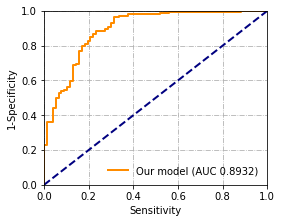

正例比例:0.6709401709401709
---------------------------Youden最佳阈值---------------------------
Youden最佳阈值： 0.82066184
[[ 59  18]
 [ 19 138]]


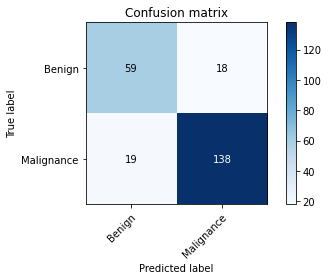

Acc: 0.8418803418803419
灵敏度: 0.8789808917197452
特异度: 0.7662337662337663
PPV: 0.8846153846153846
NPV: 0.7564102564102564
F1: 0.8817891373801917


In [12]:
# 预测函数
Evaluate(model_stage, adr_list, Size_list)

# Task2

In [13]:
model_stage = 'task2'
# 各模型所在位置
Incpt_file_adr = 'model-cut2/'+model_stage+'/'+'Inception_40_Epoch.82-0.8599.h5'
Vgg_file_adr = 'model-cut2/'+model_stage+'/'+'Vgg_60_Epoch.17-0.8535.h5'
Res_file_adr = 'model-cut2/'+model_stage+'/'+'Resnet_40_Epoch.09-0.8408.h5'
adr_list = [Incpt_file_adr, Vgg_file_adr, Res_file_adr]
# 目标视野
Size_list = [[60, 40, 20], [80, 60, 40], [60, 40, 20]]

Stage:  task2
Model:  Inception
View:  [60, 40, 20]
Current task stage: task2
train length:  10060
test length:  157
label length:  10217
Model:  Vgg
View:  [80, 60, 40]
Current task stage: task2
train length:  10060
test length:  157
label length:  10217
Model:  Resnet
View:  [60, 40, 20]
Current task stage: task2
train length:  10060
test length:  157
label length:  10217
AUC: 0.927458617332035


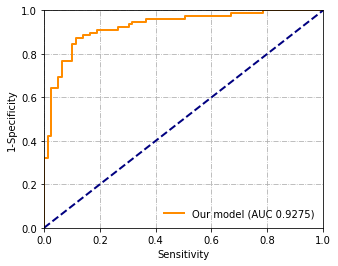

正例比例:0.4968152866242038
---------------------------Youden最佳阈值---------------------------
Youden最佳阈值： 0.5623825
[[70  9]
 [11 67]]


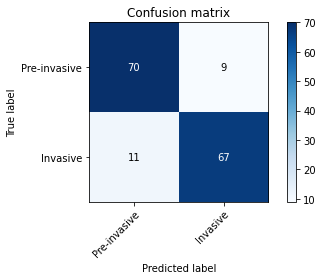

Acc: 0.8726114649681529
灵敏度: 0.8589743589743589
特异度: 0.8860759493670886
PPV: 0.881578947368421
NPV: 0.8641975308641975
F1: 0.8701298701298701


In [16]:
# 预测函数
Evaluate(model_stage, adr_list, Size_list)

## TASK3

In [15]:
model_stage = 'task3'
# 各模型所在位置
Incpt_file_adr = 'model-cut2/'+model_stage+'/'+'Inception_60_Epoch.44-0.7105.h5'
Vgg_file_adr = 'model-cut2/'+model_stage+'/'+'Vgg_80_Epoch.09-0.7237.h5'
Res_file_adr = 'model-cut2/'+model_stage+'/'+'Resnet_40_Epoch.04-0.7237.h5'
adr_list = [Incpt_file_adr, Vgg_file_adr, Res_file_adr]
# 目标视野
Size_list = [[80, 60, 40], [100, 80, 60], [60, 40, 20]]

Stage:  task3
Model:  Inception
View:  [80, 60, 40]
Current task stage: task3
train length:  4957
test length:  76
label length:  5033
Model:  Vgg
View:  [100, 80, 60]
Current task stage: task3
train length:  4957
test length:  76
label length:  5033
Model:  Resnet
View:  [60, 40, 20]
Current task stage: task3
train length:  4957
test length:  76
label length:  5033
Acc: 0.7368421052631579


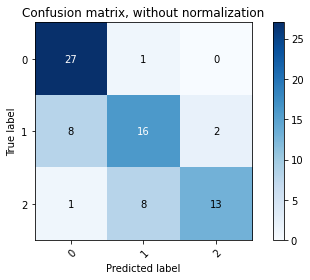

In [16]:
# 预测函数
Evaluate(model_stage, adr_list, Size_list)